In [1]:
%load_ext autoreload
%reload_ext autoreload
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

env: JAX_PLATFORM_NAME=cpu


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax

from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt

from jaxtyping import Float, Array, Int

from n3.architecture.controller import StandardController, ControllerLike
from n3.architecture.model import N3, ModelLike

from n3.utils.utils import grad_norm
from n3.utils.metrics import accuracy, cross_entropy, confusion_matrix
from n3.data import spiral

### Config

In [3]:
n_samples = 2**15
num_classes = 5
test_size = 0.2

seed = 0
key = jax.random.PRNGKey(seed)
N_max = 10  # per layer max number of neurons
size_influence = 0.32
epochs = 5_000
print_every = 100

### Dataset

In [4]:
x_train, x_test, y_train, y_test = spiral.generate_data(
    n_samples=n_samples,
    num_classes=num_classes,
    test_size=test_size,
    scaler=MinMaxScaler(feature_range=(-1, 1)),
    seed=seed,
)

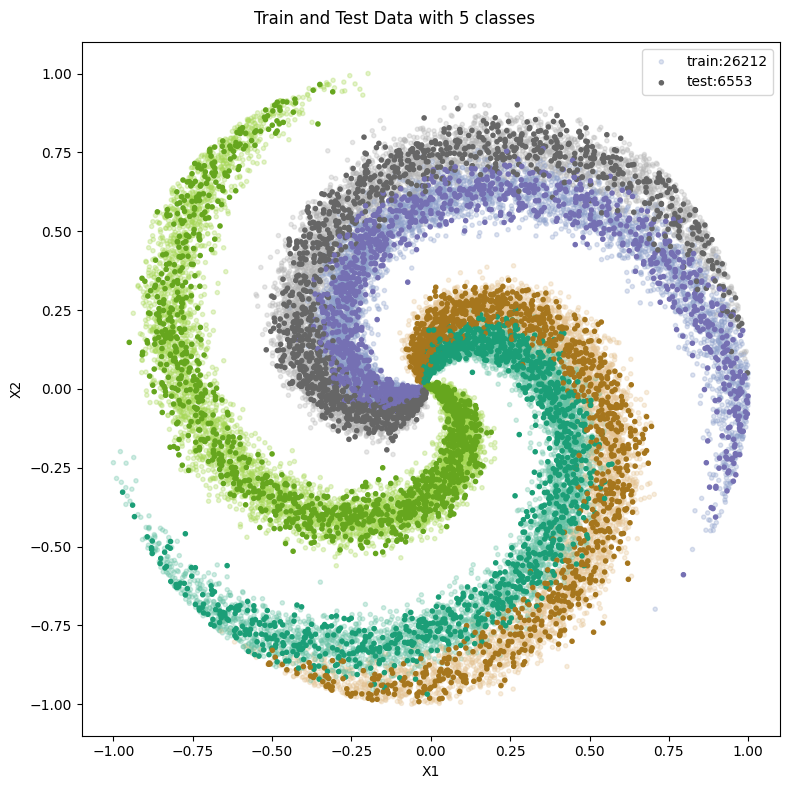

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    x_train[:, 0],
    x_train[:, 1],
    c=y_train,
    cmap="Set2",
    label=f"train:{len(x_train)}",
    alpha=0.3,
    marker=".",
)
ax.scatter(
    x_test[:, 0],
    x_test[:, 1],
    c=y_test,
    cmap="Dark2",
    label=f"test:{len(x_test)}",
    alpha=1,
    marker=".",
)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
plt.suptitle(f"Train and Test Data with {len(np.unique(y_train))} classes")
ax.legend()
plt.tight_layout()

### Training scheme

In [6]:
def compute_base_loss(
    model: ModelLike,
    control: ControllerLike,
    x: Float[Array, "batch 2"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    pred_y = jax.nn.log_softmax(jax.vmap(model, in_axes=(0, None))(x, control))
    loss = cross_entropy(y, pred_y)
    return loss

In [7]:
def compute_size_loss(
    controller: ControllerLike, size_influence: float
) -> Float[Array, ""]:
    N = controller(jnp.ones((1,)))
    return size_influence * jnp.mean((N - 1.0) ** 2)

In [8]:
@eqx.filter_jit
def make_step(
    model: ModelLike,
    controller: ControllerLike,
    size_influence: float,
    x: Float[Array, "batch 2"],
    y: Int[Array, "batch"],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> tuple[Float[Array, ""], ModelLike, ControllerLike, optax.OptState]:
    loss_base, grads_base = eqx.filter_value_and_grad(compute_base_loss)(
        model, controller, x, y
    )
    loss_size, grads_size = eqx.filter_value_and_grad(compute_size_loss)(
        controller, size_influence
    )
    loss = loss_base + loss_size

    updates, opt_state = optim.update([grads_base, grads_size], opt_state)

    model = eqx.apply_updates(model, updates[0])  # type: ignore
    controller = eqx.apply_updates(controller, updates[1])  # type: ignore
    return loss, model, controller, opt_state

In [9]:
@eqx.filter_jit
def test_step(
    model: ModelLike,
    controller: ControllerLike,
    size_influence: float,
    x: Float[Array, "batch 2"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    return compute_base_loss(model, controller, x, y) + compute_size_loss(
        controller, size_influence
    )

In [10]:
model_key, control_key = jax.random.split(key)
n3 = N3(2, num_classes, [N_max], model_key)
control = StandardController(1, control_key)

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(eqx.filter([n3, control], eqx.is_inexact_array))

In [11]:
epoch_list = []
test_losses = []
test_accuracies = []
train_losses = []
controls = []
base_grad_norms = []
control_grad_norms = []

for epoch in range(epochs):
    train_loss, n3, control, opt_state = make_step(
        n3, control, size_influence, x_train, y_train, optim, opt_state
    )

    if epoch % print_every == 0:
        epoch_list.append(epoch)
        test_loss = test_step(n3, control, size_influence, x_test, y_test)
        test_accuracy = accuracy(n3, control, x_test, y_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        controls.append(control.params.item())
        control_grad_norms.append(
            grad_norm(eqx.filter_grad(compute_size_loss)(control, size_influence))
        )
        print(
            f"epoch: {epoch_list[-1]}, train_loss: {train_losses[-1]:.4e}, test_loss: {test_losses[-1]:.4e}, test_accuracy: {test_accuracies[-1]:.4f}"
        )
        print(
            f"control2: {controls[-1]:.4e}, Control_grad_norm: {control_grad_norms[-1]:.4e}"
        )

epoch: 0, train_loss: 1.9498e+00, test_loss: 1.9532e+00, test_accuracy: 0.1970
control2: 9.7511e-07, Control_grad_norm: 6.3937e-01
epoch: 100, train_loss: 1.8764e+00, test_loss: 1.8783e+00, test_accuracy: 0.1970
control2: 9.8409e-03, Control_grad_norm: 5.7651e-01
epoch: 200, train_loss: 1.8183e+00, test_loss: 1.8192e+00, test_accuracy: 0.1970
control2: 3.7022e-02, Control_grad_norm: 5.1686e-01
epoch: 300, train_loss: 1.7570e+00, test_loss: 1.7577e+00, test_accuracy: 0.3127
control2: 7.8614e-02, Control_grad_norm: 4.6056e-01
epoch: 400, train_loss: 1.6580e+00, test_loss: 1.6603e+00, test_accuracy: 0.3081
control2: 1.3178e-01, Control_grad_norm: 4.0767e-01
epoch: 500, train_loss: 1.5168e+00, test_loss: 1.5238e+00, test_accuracy: 0.3080
control2: 1.9380e-01, Control_grad_norm: 3.5826e-01
epoch: 600, train_loss: 1.4049e+00, test_loss: 1.4158e+00, test_accuracy: 0.3189
control2: 2.6206e-01, Control_grad_norm: 3.1237e-01
epoch: 700, train_loss: 1.3247e+00, test_loss: 1.3374e+00, test_accurac

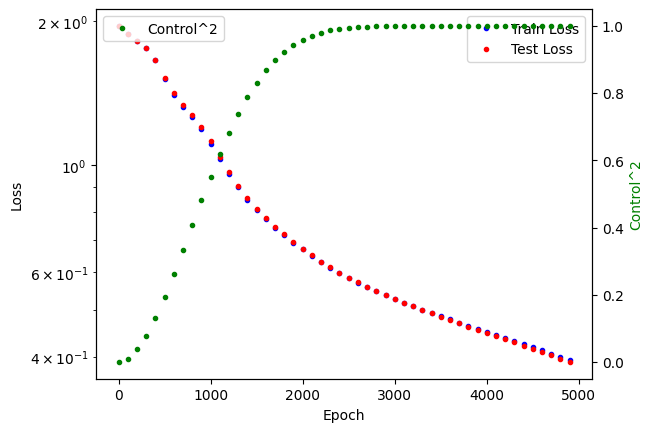

In [12]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(epoch_list, train_losses, "b.", label="Train Loss")
ax1.plot(epoch_list, test_losses, "r.", label="Test Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="k")
ax1.set_yscale("log")
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(
    epoch_list, jnp.sin((jnp.pi / 2) * jnp.array(controls)) ** 2, "g.", label="C_norm"
)
ax2.set_ylabel("Control", color="g")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

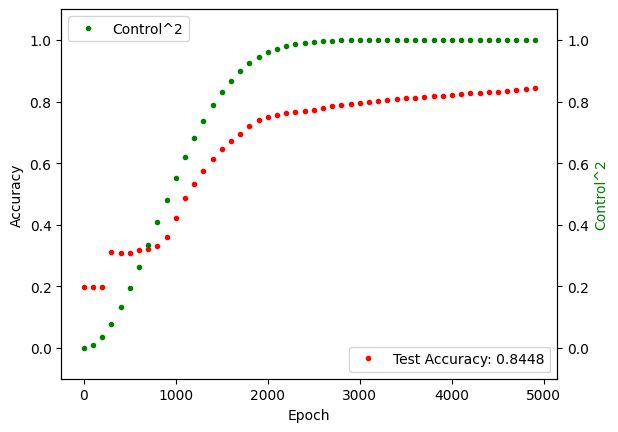

In [13]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(
    epoch_list, test_accuracies, "r.", label=f"Test Accuracy: {test_accuracies[-1]:.4f}"
)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy", color="k")
ax1.set_ylim(-0.1, 1.1)
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(
    epoch_list, jnp.sin((jnp.pi / 2) * jnp.array(controls)) ** 2, "g.", label="C_norm"
)
ax2.set_ylabel("Control", color="g")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

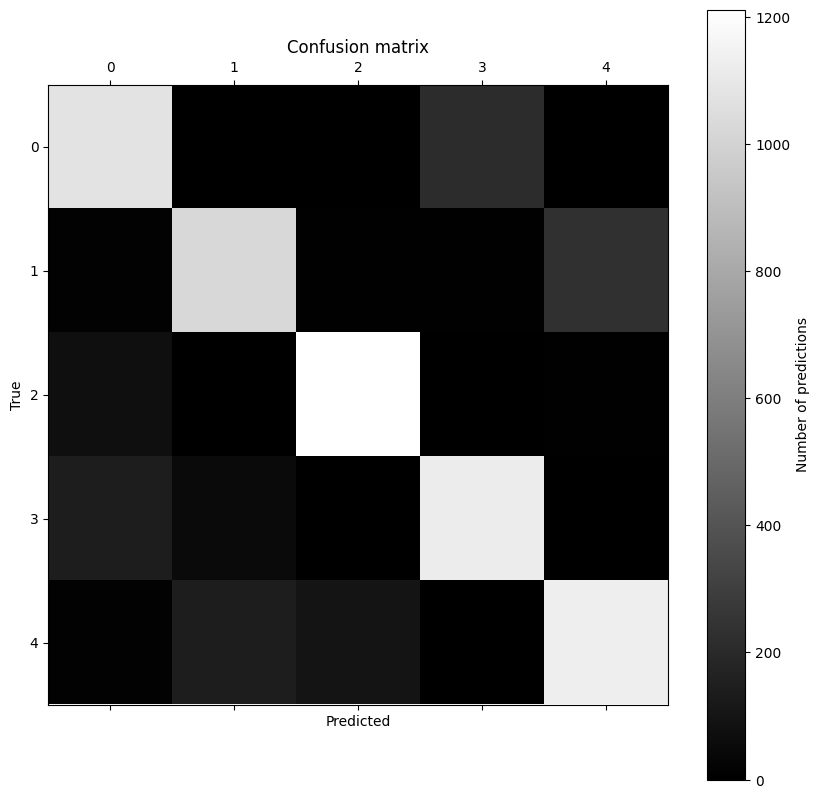

In [14]:
cmat = confusion_matrix(n3, control, x_test, y_test)

fig, ax = plt.subplots(figsize=[10, 10])
cax = ax.matshow(cmat, cmap="gray")
fig.colorbar(cax, label="Number of predictions")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")

Text(0.5, 1.0, 'Decision boundary')

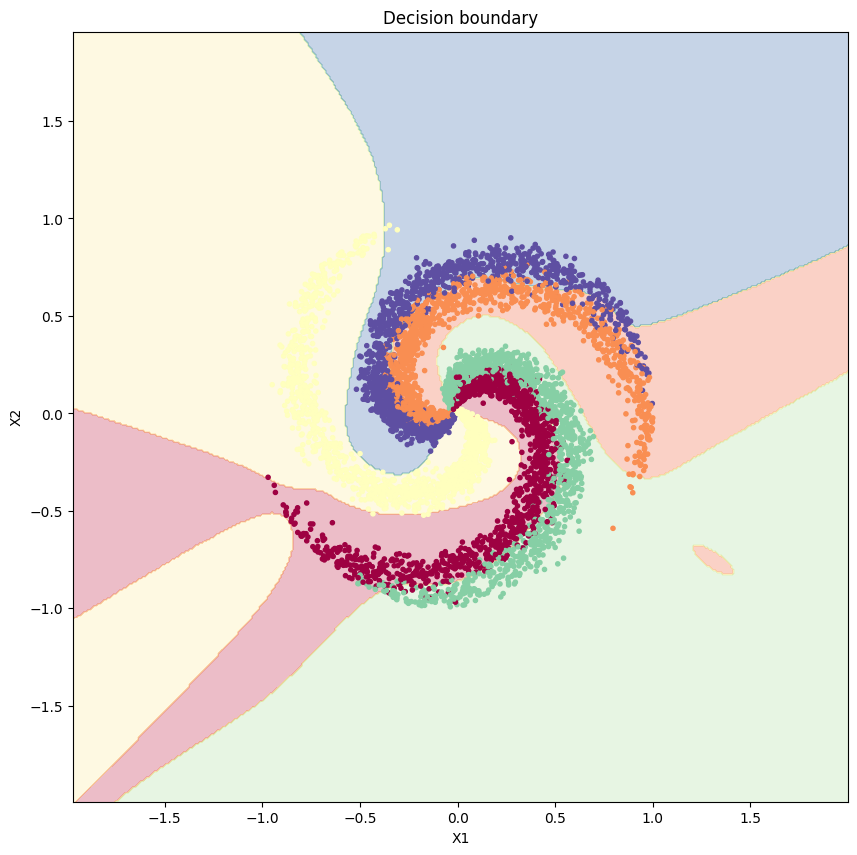

In [15]:
# plot decision boundary
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = jax.nn.softmax(
    jax.vmap(n3, in_axes=(0, None))(np.c_[xx.ravel(), yy.ravel()], control)
)
Z = np.argmax(Z, axis=-1)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=[10, 10])
ax.contourf(xx, yy, Z, alpha=0.3, cmap="Spectral")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap="Spectral", marker=".")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision boundary")